# Stage 2: Classification (sort of...)
Classification is the hardest part of the 4-stage process because:
1. As seen in the presentation, features for the 5 different subclasses in Montserrat have large overlap.
2. There may be a continuum in frequency content from LP -> Hybrid -> VT earthquakes, and the different frequency content might only result from the subtle differences in the source.
3. Sometimes an event can look like a different class on different stations, suggesting radiation pattern, path, and site effects may be as important as the source mechanism in determining the waveforms we see.
4. Different analysts have their own biases, so classification is highly subjective.

## What about Machine Learning?
In January 2001, we began exploring using neural networks to provide an objective classification of Montserrat events. Two papers resulted, but the results were not good enough to operationalize. More recently, I've implemented the methodology of Malfante et al. (2018), and I'm trying to examine how many distinct event classes the data support, but this remains a work in progress. Many observatories do now routinely use machine learning in real-time to classify events, but models trained on the seismicity at one volcano and for a particular time period are not generally applicable to seismicity at all volcanoes, at all times. So this topic is beyond our scope today.

## Frequency ratio
For this simple presentation, we will quantify and classify each signal based on its frequency features. We will break down each signal between the trigger ON and trigger OFF times into 2.56-s time windows, and compute the "Frequency Ratio", which is a base-2 logarithm of the amplitude ratio of the VT frequency band versus the LP frequency band:


\begin{align}
fratio & = log_{2} \frac {A_{VT}}{A_{LP}} \\
\end{align}

                                                                        (Rodgers et al., 2016)

We use the following definitions of the VT and LP bands:

<table border=1>
    <tr><td>Class</td><td>Frequency Band (Hz)</td></tr>
    <tr><td>LP</td><td>0.8 - 4.0</td></tr>
    <tr><td>VT</td><td>4.0 - 18.0</td></tr>
</table>

This means if the duration (trigger OFF - trigger ON time) of a signal is 25.6 s, and we use 6 channels, we get 60 separate measurements of frequency ratio. The time evolution of the signal is important in deciding if the signal is a hybrid, because a hybrid has a VT onset and an LP coda.

## Examples:
1. We compute the frequency ratios for 1 event.
2. We compute the frequency ratios for each event in the catalog.

We will use the catalog we just generated from 10 days of continuous MVO seismic data, and see how the frequency ratio changes before and after the large dome collapse that began at 02:00 UTC on 13th July 2003.

First, we will load the catalog from the previous notebook:


In [1]:
import os
import sys
import pandas as pd
import obspy
sys.path.append('../lib')
import vsmTools
from SAM import RSAM

DATA_DIR = os.path.join('..', '..', 'data')
EVENTS_DIR = os.path.join(DATA_DIR, 'events')
CATALOG_DIR = os.path.join(DATA_DIR,'catalogs')
SAMPLING_INTERVAL = 2.56

catObj = vsmTools.load_catalog(CATALOG_DIR,'catalog_MV_20030712')
print(catObj)
catDF = catObj.to_dataframe()

4314 Event(s) in Catalog:
2003-07-09T00:00:15.973333Z | None, None | 0.44 None
2003-07-09T00:10:52.493333Z | None, None | 0.93 None
...
2003-07-15T23:22:25.520000Z | None, None | 0.70 None
2003-07-15T23:49:44.840000Z | None, None | 0.25 None
To see all events call 'print(CatalogObject.__str__(print_all=True))'


## Example 1: Compute  the frequency ratio for 1 event

2003-07-11T05:55:03.186667Z


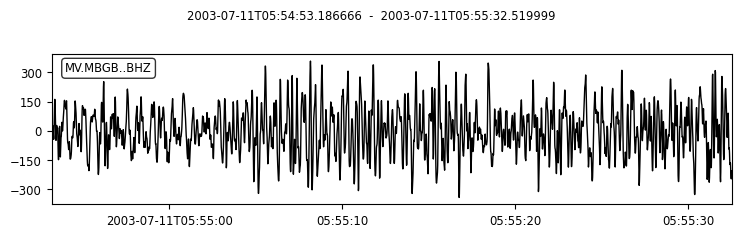

Average Frequency Ratio for whole event: -0.0


In [10]:
def compute_fratio(st, evtime, duration, plot_streams=False, sampling_interval=2.56):
    for tr in st:
        tr.stats['units'] = 'Counts'
    st.detrend('linear')
    st.trim(starttime=evtime, endtime=evtime+duration)
 
    # Generate an RSAM object
    rsamObj = RSAM(stream=st, sampling_interval=sampling_interval)
            
    dfratio = pd.DataFrame()
    for i, seed_id in enumerate(rsamObj.dataframes):
        df = rsamObj.dataframes[seed_id]
        if i==0:
            dfratio['datetime'] = [obspy.core.UTCDateTime(t).datetime for t in df['time']]
        dfratio[seed_id] = df['fratio']
    dfratio['mean'] = dfratio.mean(axis=1, numeric_only=True)
    print(f"Average Frequency Ratio for whole event: {dfratio['mean'].mean():.1f}")

    return rsamObj, dfratio

# read the 1000'th event in the catalog
eventIndex = 2200
row = catDF.iloc[eventIndex]
this_trig = catObj.triggers[eventIndex]
evtime = obspy.UTCDateTime(row['datetime'])
print(evtime)

# load corresponding miniseed file
year = evtime.strftime('%Y')
month = evtime.strftime('%m')
duration = row['duration']
mseedfile = os.path.join(EVENTS_DIR, 'WAV', 'MV', year, month, row['filename'] + '.mseed')
st = obspy.read(mseedfile, 'MSEED')

#st.trim(obspy.UTCDateTime(2003,7,10,21,57,4), obspy.UTCDateTime(2003,7,10,21,57,16))

# plot Stream (just final Trace)
st[0].plot()

# compute and plot frequency ratio
rsamObj, dfratio = compute_fratio(st, evtime, duration, plot_streams=True, sampling_interval=SAMPLING_INTERVAL)
#dfratio.plot(x='datetime', style='o', ylabel='Frequency Ratio')





In [3]:
from vsmTools import classify_event

subclass = classify_event(dfratio, rsamObj, this_trig, sampling_interval=SAMPLING_INTERVAL)
print(subclass)

r


## Example 2: Compute the frequency ratios and guess subclass for each event in the catalog

In [23]:
dfratioPickle=os.path.join(CATALOG_DIR,'dfratio_MV_20030712_.pkl')

if os.path.isfile(dfratioPickle):
    dfratio_all = pd.read_pickle(dfratioPickle)
else:
    # process events
    subclasses = []
    dfratio_all = None
    prevYmdh = '0000/00/00 00:00'

    for index, row in catDF.iterrows():
        evtime = obspy.UTCDateTime(row['datetime'])
        duration = row['duration']
        Ymdh = evtime.strftime('%Y/%m/%d %H:00')
        if Ymdh > prevYmdh:
            print(f'Processing {Ymdh} ...')
            prevYmdh = Ymdh
        mseedfile = os.path.join(EVENTS_DIR, 'WAV', 'MV', Ymdh[0:4], Ymdh[5:7], row['filename'] + '.mseed')    
        st = obspy.read(mseedfile, format='MSEED')
        rsamObj, dfratio = compute_fratio(st, evtime, duration, sampling_interval=SAMPLING_INTERVAL)

        this_trig = catObj.triggers[index]

        try: 
            subclass = classify_event(dfratio, rsamObj, this_trig, sampling_interval=SAMPLING_INTERVAL)
            subclasses.append(subclass)
        except:
            subclasses.append('n')
        #print(subclasses)
        
        if len(dfratio)==0:
            dfratio_all = dfratio
        else:
            dfratio_all = pd.concat([dfratio_all, dfratio])
    catObj.classifications = subclasses
    dfratio_all.to_pickle(dfratioPickle)

In [22]:
#print(catObj.classifications)
for subclass in ['r', 'e', 'l', 'h', 't', 'n']:
    print(subclass, catObj.classifications.count(subclass))

r 2896
e 13
l 14
h 511
t 879
n 1


## Plot frequency ratio and magnitude versus time

Index(['mean', 'datetime', 'MV.MBGB..BHZ', 'MV.MBGH..BHZ', 'MV.MBLG..SHZ',
       'MV.MBLY..BHZ', 'MV.MBRV..SHZ', 'MV.MBRY..BHZ', 'MV.MBSS..SHZ',
       'MV.MBWH..SHZ'],
      dtype='object')


[12241.650550115735,
 12249.342514853397,
 12241.650550115735,
 12249.342514853397]

<Figure size 640x480 with 0 Axes>

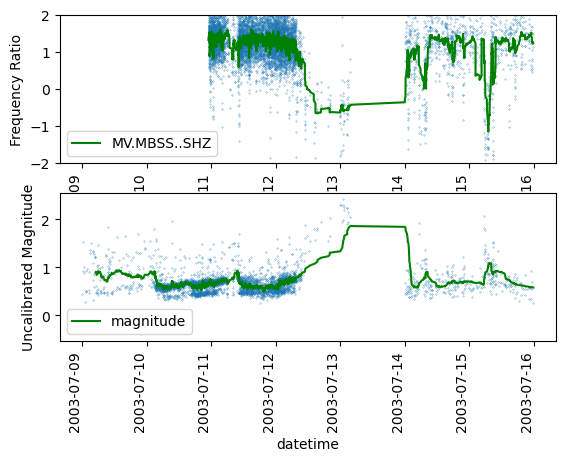

In [32]:
import matplotlib.pyplot as plt
dfratio_rolling = dfratio_all.copy()
print(dfratio_all.columns)
fig = plt.figure()
fig, ax = plt.subplots(2,1)
col = 'MV.MBSS..SHZ'
dfratio_rolling.plot.scatter(ax=ax[0], x='datetime', y=col, s=0.05, rot=90, ylabel='Frequency Ratio')
dfratio_rolling[col] = dfratio_rolling[col].rolling(30).mean()
dfratio_rolling.plot.line(ax=ax[0], x='datetime', y=col, style='g', rot=90, ylabel='Frequency Ratio')
ax[0].set_ylim([-2.0, 2.0])

catDF.plot.scatter(ax=ax[1], x='datetime', y='magnitude', s=0.05, rot=90, ylabel='Uncalibrated Magnitude')
catDF_rolling = catDF.copy()
catDF_rolling['magnitude'] = catDF_rolling['magnitude'].rolling(30).mean()
catDF_rolling.plot.line(ax=ax[1], x='datetime', y='magnitude', style='g', rot=90)
plt.setp(ax, xlim=ax[1].get_xlim())

### Observations:
- From around 2003/07/12 08:00, as magnitudes increase, frequency ratio drops.


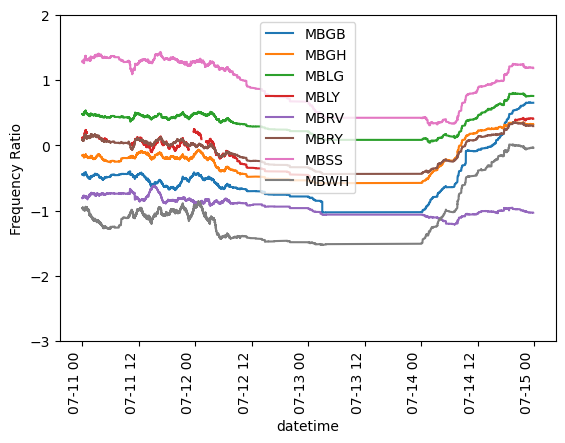

In [34]:
from datetime import datetime 
dfratio_subset= dfratio_all.loc[(dfratio_all['datetime'] >= datetime(2003,7,10, 18, 0, 0)) & (dfratio_all['datetime'] <= datetime(2003,7,15))]
dfratio_rolling = dfratio_subset.copy()

fig1 = plt.figure()
ax1 = fig1.add_subplot(1,1,1)
for col in dfratio_all.columns:
    if col[0:2]=='MV':
        network, station, location, channel = col.split('.')
        dfratio_rolling[col] = dfratio_rolling[col].rolling(300).mean()
        dfratio_rolling.plot.line(ax=ax1, x='datetime', y=col, rot=90, ylabel='Frequency Ratio', label=station)
        ax1.set_ylim([-3.0, 2.0])

In [ ]:
'''
# Define a source location for Redoubt volcano. Station distances to this lat/lon are used to "reduce" the displacement to 1 km distance.
source = {'lat':60.4845, 'lon':-152.7392}
print(source)

# Generate a Reduced Displacement object, assuming body waves (surfaceWaves=False) and no inelastic attenuation (Q=None)
DRobj = dsamObj.compute_reduced_displacement(inv, source, surfaceWaves=False, Q=None)
DRobj.plot()

# Generate a Reduced Displacement object, assuming surface waves (surfaceWaves=True) and no inelastic attenuation (Q=None)
DRSobj = dsamObj.compute_reduced_displacement(inv, source, surfaceWaves=True, Q=None)
DRSobj.plot()
'''